In [61]:
from network.examples import community, virus
from network.simulation import rv, test, run_simulations, create_runner
from network.randoms import fix_random
from network.graph import Graph

import random
from itertools import chain
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Structure of the network

We start formulating the structure of the graph on the idea of "communities", that is, sub-groups within the graph whose members have close connections with one another. These simulate the existence of families, households, and roommates. I call these **core connections**. 

Outside of core connections exist **strong connections**, those between people of different households but still have significant interaction/time spent together. Examples of these include coworkers and friends hanging out together.

Finally, we have we **weak connections**, where people of different households engage in casual, limited contact. These include people you only briefly interact with at work, a casual conversation with a stranger, or service workers engaging with customers.

**Graph parameters**

* `n_communities` = number of communities/households
* `community_size` = household size
* `orphans` = number of single people with only outside connections
* `total_people` = total # of people in simulation, calculated by adding people in households to number of "orphans"
* `n_strong_conns` = total # of strong connections in the graph. I generally put it as some multiple of people in the simulation - for example, if each person had 3 strong connections outside their household, this would be `1.5 * total_people`.
* `n_weak_conns` = total # of weak connections in the graph. Similar idea as `n_strong_conns`.

**Strength parameters**

Each category of connections has an average _strength_, a measure of the likelihood of transmission across those edges. Not surprisingly, core connections would have the highest strength, followed by strong and then weak connections, based on time and closeness spent together in a closed space. These are set in `core_strength`, `strong_strength`, and `weak_strength`.

Regarding strong connections, we assume they are persistent - the people you interact closely with outside your household generally stays the same through a given period of time. For example, the coworkers and friends you interact with today, you'll likely interact with tomorrow as well. The same cannot be said for a customer at a restaurant who acts as a weak interaction for a waiter.

* `p_strong_interact` = probability on any given day any given strong interaction will recur.

With those parameters set, we can generate a base or template graph which we will use in our simulations, stored in the variable `graph0`.

In [237]:
n_communities = 800
community_size = 3
orphans = 800
total_ppl = n_communities * community_size + orphans

n_strong_conns = int(total_ppl * 1.5)
n_weak_conns = n_strong_conns

core_strength = 0.6
strong_strength = 0.4
p_strong_interact = 5 / 7
weak_strength = 0.1

def generate_graph():
    graph, node_community_map = community.community_graph(
        n_communities, community_size, orphans,
        n_strong_conns, n_weak_conns,
        core_kw={'strength': core_strength}, 
        strong_kw={'strength': strong_strength}, 
        weak_kw={'strength': weak_strength}
    )
    return graph

with fix_random():
    graph0 = generate_graph()

# Vaccine Rollout Strategies

## Rollout strategy #1 - randomly select people to vaccinate

Control strategy - completely random rollout.

In [289]:
def vaccination_random(runner):
    nodes = [n for n in graph0.nodes]
    with fix_random():
        random.shuffle(nodes)
    return (n for n in nodes if n not in runner.deaths)

## Rollout strategy #2 - prioritized those who haven't gotten the virus yet

Those who have already gotten the virus are supposedly more immune to it (in this simulation they are _completely_ immune). So this strategy starts vaccinating those who don't have immunity.

In [276]:
def vaccination_skipping_survivors(runner):
    nodes = [n for n in graph0.nodes]
    with fix_random():
        random.shuffle(nodes)
    g1 = (n for n in nodes if n not in runner.deaths and n not in runner.survived)
    g2 = (n for n in nodes if n not in runner.deaths and n not in runner.vaccinated)
    return chain(g1, g2)

## Rollout strategy #3 - Vaccinate "essential workers" first

In this case we define essential workers as those who have a larger than normal number of strong connections in the network, which obeys a sort of log-normal distribution (see below). We'll rollout based on the number of SD's above average strong connection count. (Start with those above 2 SD, then move to 1 SD, then everyone else.)

In [238]:
def ct_strong_edges(node):
    strong_edges = [edge for edge in graph0.outbound_edges(node) if edge.attr('kind') == 'strong']
    return len(strong_edges)

node_edge_ct = {node: ct_strong_edges(node) for node in graph0.nodes}

(array([166., 473., 717., 711., 527., 341., 155.,  76.,  23.,  11.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

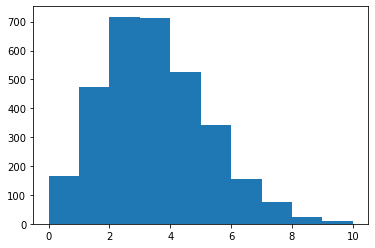

In [239]:
plt.hist(node_edge_ct.values())

In [240]:
np.mean(list(node_edge_ct.values())), np.std(list(node_edge_ct.values()))

(3.0, 1.7322312201320007)

In [282]:
def vaccination_order_by_edges(runner):
    first_priority = []
    second_priority = []
    third_priority = []
    
    edge_ct_values = list(node_edge_ct.values())
    u = np.mean(edge_ct_values)
    sd = np.std(edge_ct_values)
    for node, strong_edge_ct in node_edge_ct.items():
        if strong_edge_ct > u + 2 * sd:
            first_priority.append(node)
        elif u + 2 * sd >= strong_edge_ct > u + sd:
            second_priority.append(node)
        else:
            third_priority.append(node)
    
    with fix_random():
        random.shuffle(first_priority)
        random.shuffle(second_priority)
        random.shuffle(third_priority)
    
    for node in chain(first_priority, second_priority, third_priority):
        if node not in runner.deaths:
            yield node

## Rollout strategy #4: Vaccinate by probability of death/age

We're going to assume this imaginary virus has a mortality rate that increases exponentially with age (similar to the real mortality rate of COVID). Each person is assigned a random age that obeys a similar probability distribution to that of real-life US demographics, then the probability-of-death is determined by the age.

The average mortality rate of the virus over all ages is fixed to 4% - slightly higher than COVID, but I need a larger sample size of deaths.

Probability of death from virus is stored and saved in `p_deaths` to be used as parameters in the simulation.

In [242]:
def generate_age():
    x = random.uniform(0, 1)
    if x < 0.1:
        return random.uniform(60, 70)
    elif 0.1 <= x < 0.15:
        return random.uniform(70, 80)
    elif 0.15 <= x < 0.186:
        return random.uniform(80, 90)
    else:
        return random.uniform(0, 60)

def assign_p_death(graph, max_age=90, max_p_death=0.7, decay_factor=8):
    result = {}
    for node in graph.nodes:
        age = generate_age()
        diff = max_age - age
        p_death = max_p_death * np.exp(-diff / (max_age / decay_factor))
        result[node] = p_death
    return result

p_deaths = assign_p_death(graph0)

(array([2735.,  230.,   80.,   46.,   34.,   22.,   19.,   14.,   12.,
           8.]),
 array([2.35056010e-04, 7.01607413e-02, 1.40086426e-01, 2.10012112e-01,
        2.79937797e-01, 3.49863482e-01, 4.19789167e-01, 4.89714853e-01,
        5.59640538e-01, 6.29566223e-01, 6.99491908e-01]),
 <BarContainer object of 10 artists>)

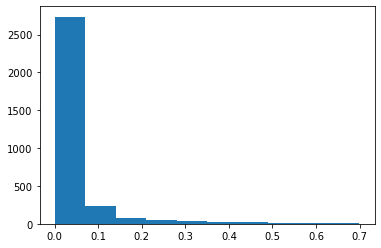

In [243]:
plt.hist(p_deaths.values())

In [244]:
np.mean(list(p_deaths.values()))

0.03935912529565273

In [283]:
def vaccination_order_by_p_death(runner):
    first_priority = []
    second_priority = []
    third_priority = []
    for node, p_death in p_deaths.items():
        if p_death > 0.15:
            first_priority.append(node)
        elif 0.05 < p_death <= 0.15:
            second_priority.append(node)
        else:
            third_priority.append(node)
            
    with fix_random():
        random.shuffle(first_priority)
        random.shuffle(second_priority)
        random.shuffle(third_priority)
    
    for node in chain(first_priority, second_priority, third_priority):
        if node not in runner.deaths:
            yield node

# Running the simulation

## Runner

The runner takes the following inputs:
1. Rollout strategy (explained above)
2. First day of vaccinations
3. Rate of vaccinations per day

The runner executes the following:
1. Apply vaccinations if we're on the first day of vaccinations
2. Determines whether a person dies or survives of the virus after transmissible period, based on previously assigned probability of death above.
3. Reset weak edges to simulate random people-to-people interactions shifting day-to-day

In [275]:
def reset_non_core_edges(transmission):
    graph = transmission.graph
    weak_edges_to_remove = [edge for edge in graph.iter_edges() if edge.attr('kind') == 'weak']
    for prev_weak_edge in weak_edges_to_remove:
        graph.remove_edge(prev_weak_edge)
        
    strong_edges = [edge for edge in graph.iter_edges() if edge.attr('kind') == 'strong']

    n_new_weak_edges = len(weak_edges_to_remove)
    for new_weak_edge in community.generate_edges(graph, n_new_weak_edges):
        graph.add_edge(new_weak_edge, kind='weak', strength=weak_strength)
        
    for edge in strong_edges:
        new_strength = strong_strength if test(p_strong_interact) else 0
        graph.update_edge(edge, strength=new_strength)
        
        
class VaccineRunner:
    def __init__(self, rollout, start_vaccine_day, daily_vaccinations):
        self.start_vaccine_day = start_vaccine_day
        self.daily_vaccinations = daily_vaccinations
        
        self.deaths = set()
        self.survived = set()
        self.vaccinated = set()
        self.rollout = rollout(self)
        
    def __call__(self, transmission):
        while True:
            if transmission.steps >= self.start_vaccine_day:
                try:
                    for _ in range(self.daily_vaccinations):
                        self.vaccinated.add(next(self.rollout))
                except StopIteration:
                    pass

            # tally deaths
            tracker = transmission.broadcast_tracker
            for node in tracker:
                if tracker.get(node, 9999) <= 0:
                    if node not in self.survived and test(p_deaths.get(node, 0)):
                        self.deaths.add(node)
                    else:
                        self.survived.add(node)

            # reset weak edges
            reset_non_core_edges(transmission)
            try:
                next(transmission)
                yield
            except StopIteration:
                return

In [247]:
def test_transmit(transmission, edge, vaccinated, vaccine_factor=0.05):
    edge_strength = edge.attr('strength')
    if edge.to_node in vaccinated:
        return test(edge_strength * vaccine_factor)
    return test(edge_strength)

def generate_sim(graph, runner):
    with fix_random():
        return virus.virus_simulation(
            graph=Graph.duplicate(graph),
            patient0=1,
            incubation_period=incubation_period,
            contagious_for=contagious_for,
            runner=runner,
            test_transmit=partial(test_transmit, vaccinated=runner.vaccinated)
        )

## Parameters of simulation
* `action_day`: when to start vaccinating
* `run_to`: how many days to run simulation
* `incubation_period`: how many days virus is dormant in a node/person before transmission begins
* `contagious_for`: how many days a person is contagious
* `daily_vaccinations`: rate of vaccinations given/day

In [255]:
action_day = 45
run_to = 100
incubation_period = rv.randint(1, 10)
contagious_for = rv.choice(0, 1, 2)
daily_vaccinations = 50

## Run the simulations

WARNING: these take a while.

In [249]:
control_runner = VaccineRunner(
    rollout=vaccination_order_by_p_death,
    start_vaccine_day=9999,
    daily_vaccinations=daily_vaccinations
)
control = generate_sim(graph0, control_runner)

result_control = run_simulations(
    control, to=run_to
)

In [269]:
vaccinate_random_runner = VaccineRunner(
    rollout=vaccination_random,
    start_vaccine_day=action_day,
    daily_vaccinations=daily_vaccinations
)
vaccinate_random_order = generate_sim(graph0, vaccinate_random_runner)

result_vaccinate_random = run_simulations(
    vaccinate_random_order,
    to=run_to
)

In [278]:
vaccinate_skip_survivor_runner = VaccineRunner(
    rollout=vaccination_skipping_survivors,
    start_vaccine_day=action_day,
    daily_vaccinations=daily_vaccinations
)
vaccinate_skip_survivor = generate_sim(graph0, vaccinate_skip_survivor_runner)

result_skip_survivor = run_simulations(
    vaccinate_skip_survivor, 
    to=run_to
)

In [284]:
vaccinate_elderly_first_runner = VaccineRunner(
    rollout=vaccination_order_by_p_death,
    start_vaccine_day=action_day,
    daily_vaccinations=daily_vaccinations
)
vaccinate_elderly_first = generate_sim(graph0, vaccinate_elderly_first_runner)

result_elderly = run_simulations(
    vaccinate_elderly_first,
    to=run_to
)

In [285]:
vaccinate_essential_first_runner = VaccineRunner(
    rollout=vaccination_order_by_edges,
    start_vaccine_day=action_day,
    daily_vaccinations=daily_vaccinations
)
vaccinate_essential_first = generate_sim(graph0, vaccinate_essential_first_runner)

result_essential = run_simulations(
    vaccinate_essential_first,
    to=run_to
)

# Results

## Deaths

The control run without vaccinations resulted in the most deaths. Randomly vaccinating saved a few lives, but not as many as the more focused strategies discussed above.

Targeting those with no immunity and targeting essential workers saved similar numbers of lives in this run. By and far the most effective campaign from a morality perspective, vaccinating elderly first saved 2/3 of the 120 lives that would have been lost, about 4x as many lives as a random vaccination campaign, and 2x that of the other targeted strategies.

In [286]:
dict(
    control=len(control_runner.deaths), 
    random_vaccination=len(vaccinate_random_runner.deaths),
    skip_survivors=len(vaccinate_skip_survivor_runner.deaths),
    elderly_first=len(vaccinate_elderly_first_runner.deaths), 
    essential_workers_first=len(vaccinate_essential_first_runner.deaths)
)

{'control': 122,
 'random_vaccination': 105,
 'skip_survivors': 92,
 'elderly_first': 44,
 'essential_workers_first': 92}

In [287]:
def sim_sequence(sim, n):
    for i in range(n):
        index = -1 if i >= len(sim.history) else i
        yield sim.history[index].broadcasts

def plot(results, labels=None):
    fig = plt.figure(figsize=(12, 12))
    plt.title('Virus transmission vs. T (days)', fontsize=16)
    lines = []
    for sim in results:
        line, = plt.plot(range(run_to), list(sim_sequence(sim, run_to)), 'o-')
        lines.append(line)

    if labels:
        plt.legend(lines, labels, loc='upper left')
    plt.xlabel('Days elapsed')
    plt.ylabel('Cases')

## Limiting transmission

All vaccination campaigns did a good job of limiting transmission *when applied early enough*. Even applying at the beginning of exponential growth, the transmission still got to around 2/3 of the population due to the power of exponential growth and the linear growth of the number of vaccinations.

The random vaccinations and elderly-first rollouts limited transmission similarly - which makes sense because age and mortality was randomly applied, so both are really randomly applying vaccinations when decoupled from the mortality aspect. The essential worker and immune rollouts were moderately more effective, but not as much as one would expect. This may allude to the fact that most transmission occurs across households via core connections rather than strong connections that essential workers have with the rest of society.

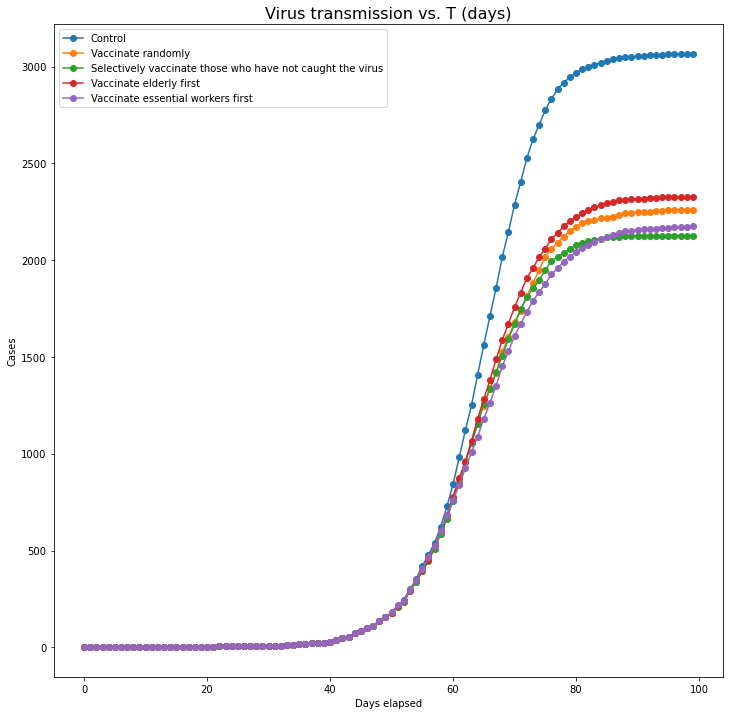

In [288]:
plot(
    [control, vaccinate_random_order, result_skip_survivor, result_elderly, result_essential],
    ['Control', 'Vaccinate randomly', 'Selectively vaccinate those who have not caught the virus', 
     'Vaccinate elderly first', 'Vaccinate essential workers first']
)